Timestep 1500.7444 ss
Run time 165.12s/2.75m


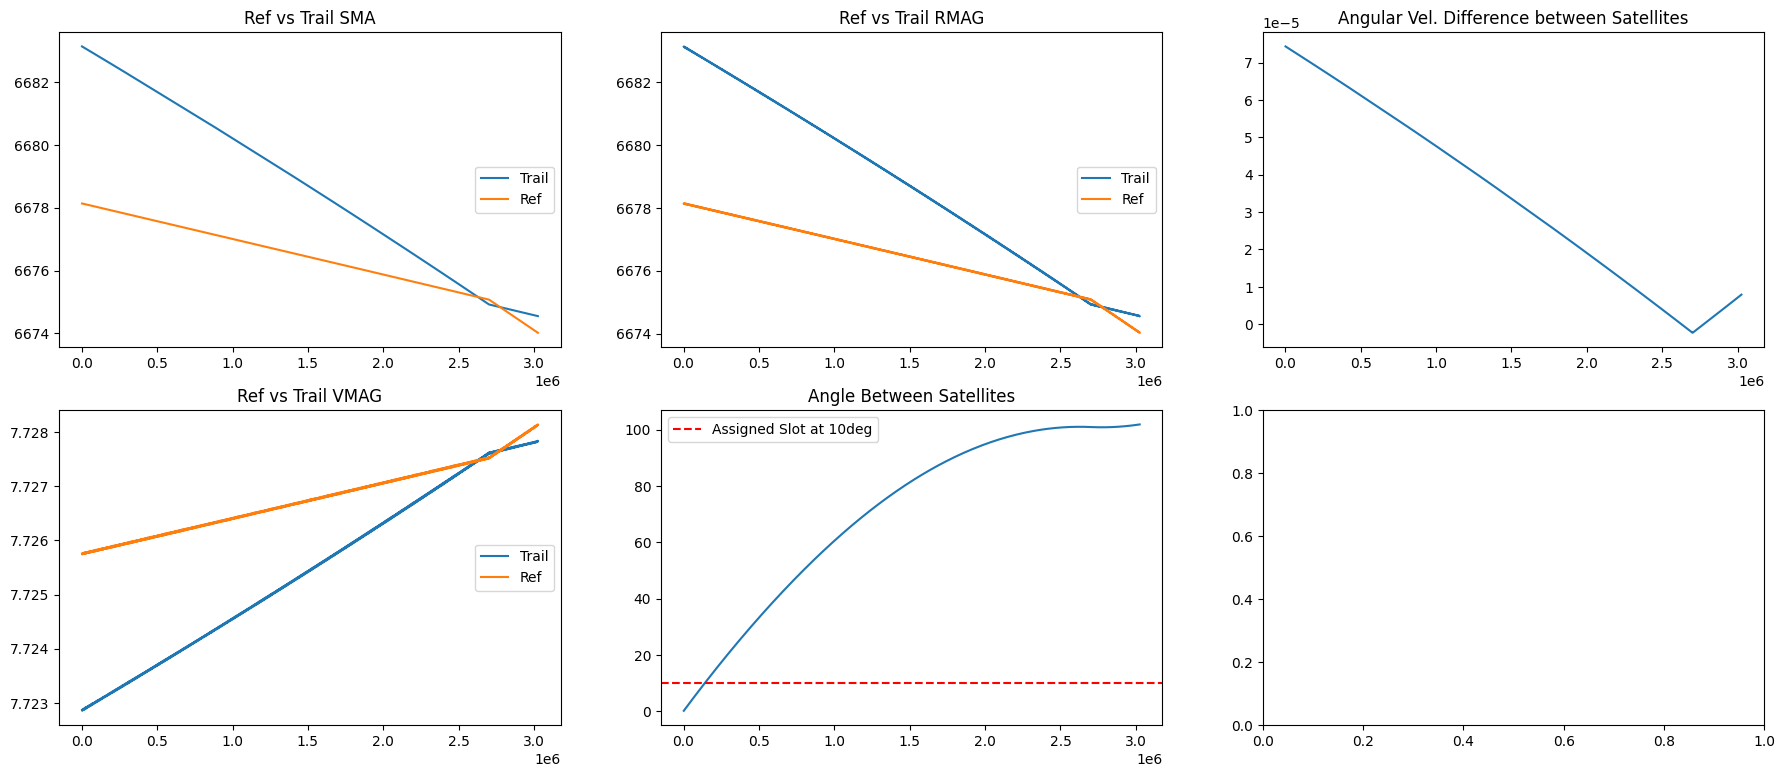

In [22]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.twobody.events import LithobrakeEvent
from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth, R_mean_earth, GM_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time

from datetime import datetime, timedelta
from sso_inc import inc_from_alt, raan_from_ltan,angle_between

# import sys
# sys.path.append('../my_scripts')

from perturbations import pertubations_coesa_high, pertubations_coesa_low

toc = time.time()
## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    nu,
    argp,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    a+(5<<u.km),
    ecc,
    inc,
    raan,
    nu+(0<<u.deg),
    argp,
    epoch
    )

# Prop
start_date_ts = datetime.timestamp(start_date)
stop_date_ts = datetime.timestamp(start_date + timedelta(hours = 24*7*5))
sample_num = 9*1*16*7*2
timestamps = np.linspace(start_date_ts, stop_date_ts, sample_num)
time_step = (timestamps[1]-timestamps[0]) << u.s
refsmalist = []
trailsmalist = []

assignment = 10

ref_vel = []
trail_vel = []

elapsedsecs = []
secs = 0

rmag_ref = []
rmag_trail = []

vmag_ref = []
vmag_trail = []

angle_list = []

# ang_vel_ref_list = []
# ang_vel_trail_list = []
ang_vel_list = []

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 


for timestamp in range(len(timestamps)):
    secs += time_step.value
    if timestamp < 1800:
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low))
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high))
    elif timestamp >= 1800:
        reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_high))
        trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low))
    # else:
    #     reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low))
    #     trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(rtol=1e-5, f=pertubations_coesa_low))
    # reference_orbit = reference_orbit.propagate(time_step, method=CowellPropagator(f=perturbations_atm_low))
    # trailing_orbit = trailing_orbit.propagate(time_step, method=CowellPropagator(f=perturbations_atm_high))
    elapsedsecs.append(secs)
    refsmalist.append(reference_orbit.a.value)
    trailsmalist.append(trailing_orbit.a.value)

    rmag_ref.append(np.linalg.norm(reference_orbit.r.value))
    rmag_trail.append(np.linalg.norm(trailing_orbit.r.value))  

    vmag_ref.append(np.linalg.norm(reference_orbit.v.value))
    vmag_trail.append(np.linalg.norm(trailing_orbit.v.value))
    
    angle_list.append(angle_between(trailing_orbit.r.value,reference_orbit.r.value))
    
    ang_vel_ref = (360 << u.deg) / reference_orbit.period
    ang_vel_trail = (360 <<u.deg) / trailing_orbit.period
    ang_vel_diff =  ang_vel_ref - ang_vel_trail
    ang_vel_list.append(ang_vel_diff.value)


    # ang_vel_ref_list.append(ang_vel_ref.value)
    # ang_vel_trail_list.append(ang_vel_trail.value)
    #  plt.pause(0.00001)



ax[0,0].plot(elapsedsecs,trailsmalist,label='Trail')
ax[0,0].plot(elapsedsecs,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')

ax[0,1].plot(elapsedsecs,rmag_trail,label='Trail')
ax[0,1].plot(elapsedsecs,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')

ax[1,0].plot(elapsedsecs,vmag_trail,label='Trail')
ax[1,0].plot(elapsedsecs,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')

# z = np.polyfit(elapsedsecs, angle_list, 1)
# p = np.poly1d(z)

ax[1,1].plot(elapsedsecs,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')

ax[0,2].plot(elapsedsecs,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()

# plt.plot(elapsedsecs,angle)
# plt.figure(figsize=(22,12))
# plt.show()







